# Climate skill at 1&deg;: time-mean RMSE

In [21]:
from collections import namedtuple
import re
from string import ascii_lowercase

import wandb
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from utils import wandb_to_beaker_experiment, wandb_to_beaker_result, get_scalar_metrics
from constants import INFERENCE_COMPARISON_1DEG, WANDB_ENTITY, SECONDS_PER_DAY, WANDB_PROJECT

In [22]:
mpl.rc('font', size=8)

In [23]:
api = wandb.Api()
WandbRun = namedtuple('WandbRun', ['project', 'id'])
EvalVar = namedtuple('EvalVar', ['name', 'conversion_factor', 'long_name', 'units', 'scale'])
EvalMetric = namedtuple('EvalMetric', ['name', 'long_name'])

In [19]:
TIME_MEAN_EVAL_VARS = [
    EvalVar('TMP2m', None, '2-meter temperature', 'K', 0.35),
    EvalVar('PRATEsfc', SECONDS_PER_DAY, 'surface precipitation rate', 'mm/day', 0.6),
    EvalVar('total_water_path', None, 'total water path', 'mm', 1.0),
    EvalVar('h500', None, '500hPa height', 'm', 10)
]
TIME_MEAN_METRIC = EvalMetric("inference/time_mean/rmse", "RMSE of time-mean")
ALTERNATE_WANDB_PROJECT = "ace2"

In [5]:
all_metrics = [(eval_var, TIME_MEAN_METRIC) for eval_var in TIME_MEAN_EVAL_VARS]
all_metric_names = [
    '/'.join([metric.name, eval_var.name])
    for eval_var, metric in all_metrics
]
print(f"{all_metric_names=}")

all_metric_names=['inference/time_mean/rmse/TMP2m', 'inference/time_mean/rmse/PRATEsfc', 'inference/time_mean/rmse/total_water_path', 'inference/time_mean/rmse/h500']


In [6]:
metrics = {}
for duration, duration_runs in INFERENCE_COMPARISON_1DEG.items():
    for run_group_name, run_group in duration_runs.items():
        if isinstance(run_group, dict):
            for ic_name, run_id in run_group.items():
                full_key = '/'.join([duration, run_group_name, ic_name])
                print(f"Getting metrics for {full_key=}.")
                run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_id}")
                metrics[full_key] = get_scalar_metrics(run, all_metric_names)
        else:
            full_key = '/'.join([duration, run_group_name])
            print(f"Getting metrics for {full_key=}.")
            try:
                run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_group}")
            except:
                run = api.run(f"{WANDB_ENTITY}/{ALTERNATE_WANDB_PROJECT}/{run_group}")
            metrics[full_key] = get_scalar_metrics(run, all_metric_names)

Getting metrics for full_key='10yr/ERA5-ACEv2'.
Getting metrics for full_key='10yr/SHiELD-AMIP-ACEv2/IC0'.
Getting metrics for full_key='10yr/SHiELD-AMIP-ACEv2/IC1'.
Getting metrics for full_key='10yr/SHiELD-AMIP-ACEv2/IC2'.
Getting metrics for full_key='10yr/SHiELD-AMIP-reference'.
Getting metrics for full_key='10yr/SHiELD-AMIP-vs.-ERA5/IC0001'.
Getting metrics for full_key='10yr/SHiELD-AMIP-vs.-ERA5/IC0002'.
Getting metrics for full_key='82yr/ERA5-ACEv2'.
Getting metrics for full_key='82yr/SHiELD-AMIP-ACEv2/IC0'.
Getting metrics for full_key='82yr/SHiELD-AMIP-ACEv2/IC1'.
Getting metrics for full_key='82yr/SHiELD-AMIP-ACEv2/IC2'.
Getting metrics for full_key='82yr/SHiELD-AMIP-reference'.
Getting metrics for full_key='82yr/SHiELD-AMIP-vs.-ERA5/IC0001'.
Getting metrics for full_key='82yr/SHiELD-AMIP-vs.-ERA5/IC0002'.


In [24]:
metrics

{'10yr/ERA5-ACEv2': {'inference/time_mean/rmse/TMP2m': 0.22435910999774933,
  'inference/time_mean/rmse/PRATEsfc': 4.166209237155272e-06,
  'inference/time_mean/rmse/total_water_path': 0.5814387202262878,
  'inference/time_mean/rmse/h500': 7.459585189819336},
 '10yr/SHiELD-AMIP-ACEv2/IC0': {'inference/time_mean/rmse/TMP2m': 0.20374968647956848,
  'inference/time_mean/rmse/PRATEsfc': 3.208542011634563e-06,
  'inference/time_mean/rmse/total_water_path': 0.46853020787239075,
  'inference/time_mean/rmse/h500': 4.644582271575928},
 '10yr/SHiELD-AMIP-ACEv2/IC1': {'inference/time_mean/rmse/TMP2m': 0.25943225622177124,
  'inference/time_mean/rmse/PRATEsfc': 3.3920889563887613e-06,
  'inference/time_mean/rmse/total_water_path': 0.4739665687084198,
  'inference/time_mean/rmse/h500': 6.048260688781738},
 '10yr/SHiELD-AMIP-ACEv2/IC2': {'inference/time_mean/rmse/TMP2m': 0.23896406590938568,
  'inference/time_mean/rmse/PRATEsfc': 2.844255277523189e-06,
  'inference/time_mean/rmse/total_water_path': 

In [8]:
ic_key = '/IC[0-9]*$'
duration_key = '^[0-9]*yr/'
das = []
for run_name, run_metrics in metrics.items():
    run_coords = {}
    ic_match = re.search(ic_key, run_name)
    if ic_match:
        trimmed_run_name = run_name[0:ic_match.span()[0]]
        run_coords['IC'] = [ic_match.group().strip('/')]
    else:
        trimmed_run_name = run_name
    duration_match = re.search(duration_key, trimmed_run_name)
    if duration_match:
        trimmed_run_name = trimmed_run_name[duration_match.span()[1]:]
        run_coords['duration'] = [duration_match.group().strip('/')]
    else:
        trimmed_run_name = trimmed_run_name
    metric_names, metric_values = zip(*run_metrics.items())
    run_da = xr.DataArray(list(metric_values), dims='metric', coords={'metric': list(metric_names)}, name=trimmed_run_name)
    das.append(run_da.expand_dims(run_coords))
all_metrics_ds = xr.merge(das) 

In [25]:
all_metrics_ds

<xarray.Dataset> Size: 1kB
Dimensions:                (metric: 4, duration: 2, IC: 5)
Coordinates:
  * metric                 (metric) <U41 656B 'inference/time_mean/rmse/TMP2m...
  * duration               (duration) object 16B '10yr' '82yr'
  * IC                     (IC) object 40B 'IC0' 'IC0001' 'IC0002' 'IC1' 'IC2'
Data variables:
    ERA5-ACEv2             (duration, metric) float64 64B 0.2244 ... 3.563
    SHiELD-AMIP-ACEv2      (IC, duration, metric) float64 320B 0.2037 ... 6.858
    SHiELD-AMIP-reference  (duration, metric) float64 64B 0.1695 ... 1.424
    SHiELD-AMIP-vs.-ERA5   (IC, duration, metric) float64 320B nan nan ... nan

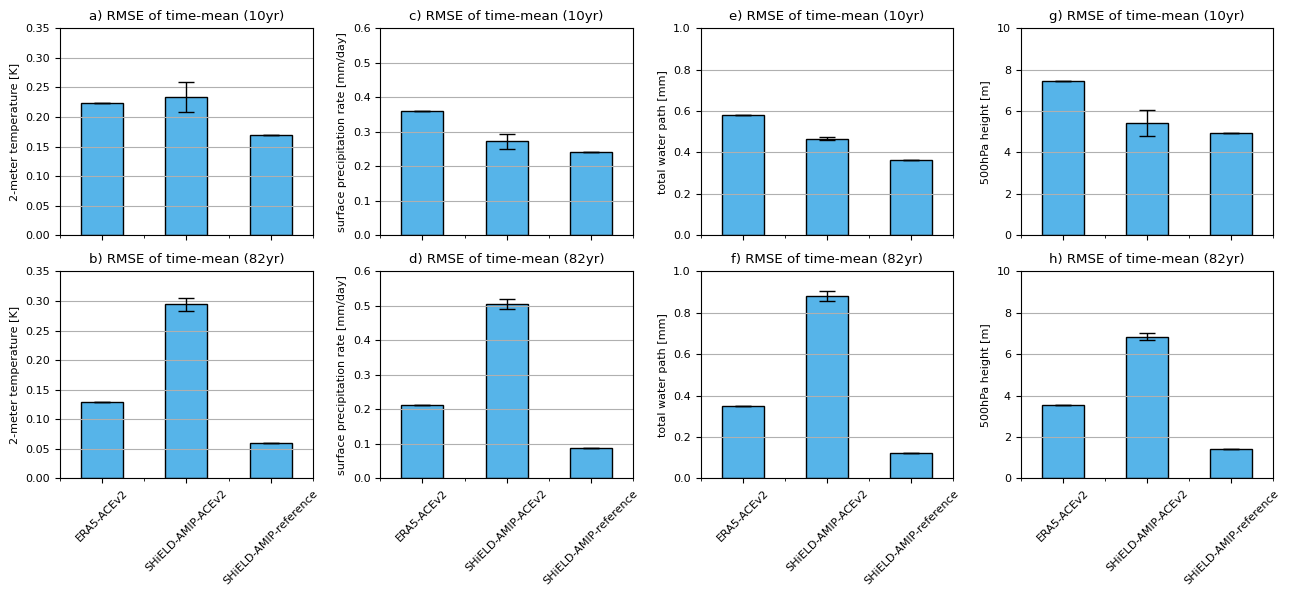

In [20]:
nrows, ncols = all_metrics_ds.sizes['duration'], len(TIME_MEAN_EVAL_VARS)
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=False)

if len(axes.shape) == 1:
    # if only plotting one variable
    axes = axes[:, None]
    
for i, variable in enumerate(TIME_MEAN_EVAL_VARS):
    full_metric_name = '/'.join([TIME_MEAN_METRIC.name, variable.name])
    for j, duration in enumerate(all_metrics_ds.duration):
        ax = axes[j, i]
        metric_ds = all_metrics_ds.sel(metric=full_metric_name, duration=duration).drop_vars(['SHiELD-AMIP-vs.-ERA5'])
        if variable.conversion_factor is not None:
            metric_ds = metric_ds * variable.conversion_factor
        mean = metric_ds.mean('IC')
        yupper = (metric_ds.max('IC') - mean)
        ylower = (metric_ds.min('IC') - mean)
        both = np.vstack([yupper.to_array().to_numpy(), ylower.to_array().to_numpy()])
        mean.to_array(dim='run_group', name=full_metric_name).to_dataframe().plot.bar(yerr=both, ax=ax, error_kw=dict(capsize=6, linewidth=1, color='k'), linewidth=1, edgecolor='k', legend=False)
        ax.set_xlabel(None)
        ax.set_ylabel(f"{variable.long_name} [{variable.units}]")
        ax.grid(axis='y')
        ax.set_ylim([0, variable.scale])
        ax.set_title(f"{ascii_lowercase[2*i + j]}) {TIME_MEAN_METRIC.long_name} ({duration.item()})")
for ax in axes[-1]:
    ax.set_xticklabels([varname.replace('_', ' ') for varname in metric_ds.data_vars], rotation=45)
fig.set_size_inches([13, 6])
fig.tight_layout()
fig.savefig('time_mean_rmse_1deg.png', bbox_inches='tight', facecolor='w')